# **Automating Data Cleaning with NLP Matcher**

* [Project Description](#project-description)
* [Preparing the Data](#preparing-the-data)
  * [Removing Emoji](#removing-emoji)
  * [Removing Stopwords](#removing-stopwords)
  * [Removing Low-value Words](#removing-low-value-words)
  * [Replacing Special Characters](#replacing-special-characters)
  * [Correcting Spelling Mistakes](#correcting-spelling-mistakes)
* [Bucketing the Data](#bucketing-the-data)
  * [Retrieving Car Brands](#retrieving-car-brands)
  * [Inferring Car Brands](#inferring-car-brands)
  * [Standardizing Car Brands](#standardizing-car-brands)
  * [Associating Listings to Car Model](#associating-listings-to-car-model)
* [Visualizing the Data](#visualizing-the-data)
* [Evaluating Accuracy](#evaluating-accuracy)

# Project Description <a name="project-description"></a>
"How much is it?"

When selling any product or services, it's crucial to get the pricing strategy **_just_** right. Sell too cheap and you're leaving money on the table; Sell too expensive and you risk losing market share. 

To achieve the perfect balance between the two, businesses often rely on market intel reports to give them a glimpse of their competitors pricing strategy. With the e-commerce industry thriving, we are now able to pull much of the information we need from the internet to serve as the foundation of our market analysis.

But as with most data found online—they're dirtier than the overdue dishes by the sink. Depending on the size of the data, it may be unrealistic to clean everything manually. The idea is to offload portions of the cleaning to scripts while not compromising the accuracy.

In this particular project, I'd like to explore the automotive spare part market in Malaysia. The focus of the project will be primarily on automating data cleaning with Natural Language Processing's matcher. The goal is to automate as much of the cleaning as possible so that businesses won't have to deploy an absurb amount of resources to produce their own market intel report.

# Preparing the Data <a name="preparing-the-data"></a>

In [1]:
import pandas as pd
import numpy as np
import re
import statistics

import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

!pip install emoji
import emoji
import string

!pip install pyxDamerauLevenshtein
from pyxdameraulevenshtein import normalized_damerau_levenshtein_distance_seqs

import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Doc
nlp = spacy.load('en_core_web_sm')

The online listings I scraped was loosely structured, featuring a free-style title and description. They don't a specific field for car brands or model and therefore it is up to the vendors to communicate that through the title and description only.

To create any meaningful insight, I would like to label them to their respective car brands and models so that a certain level of granularity can be achieved in our report.

In [2]:
df_ori = pd.read_csv('scraped_data.csv')
df_ori.head()

,LISTING DATE,LISTING TITLE,PRICE,LISTING DESCRIPTION,LISTING LOCATION
0,"2020 Jan 10, 15:10",Honda Stream RN6 RN8 RSZ Power Steering Rack ECU,RM250,Genuine Honda Stream Power Steering Rack ECU C...,Selangor
1,"2020 Jan 10, 12:00",Original steering rack toyota vellfire estima ...,RM350,Original steering rack toyota vellfire estima ...,Kuala Lumpur
2,"2020 Jan 10, 12:00",Original steering rack toyota vellfire estima ...,RM600,Original steering rack toyota vellfire estima ...,Kuala Lumpur
3,"2020 Jan 9, 19:35",ORIGINAL steering rack Alphard estima harrier,RM550,Estima acr30\nHarrier acu30\nAlphard anh10 mnh...,Kuala Lumpur
4,"2020 Jan 9, 12:20",Toyota Isis ANM10 Power Steering Rack,RM250,Toyota Isis ANM10 Power Steering Rack\nImporte...,Selangor


In [3]:
df = df_ori.copy()

df = df.replace(np.nan, '')
df = df.fillna('')

df['LISTING TITLE_copy'] = df['LISTING TITLE']
df['LISTING DESCRIPTION_copy'] = df['LISTING DESCRIPTION']

df['LISTING DATE_month'] = [datetime.datetime.strptime(yearMonth, '%Y %b %d, %H:%S').strftime('%Y-%m') for yearMonth in df['LISTING DATE']]
df['PRICE'] = df['PRICE'].str.replace('RM', '').str.replace(',', '').astype(int)

df.head()

,LISTING DATE,LISTING TITLE,PRICE,LISTING DESCRIPTION,LISTING LOCATION,LISTING TITLE_copy,LISTING DESCRIPTION_copy,LISTING DATE_month
0,"2020 Jan 10, 15:10",Honda Stream RN6 RN8 RSZ Power Steering Rack ECU,250,Genuine Honda Stream Power Steering Rack ECU C...,Selangor,Honda Stream RN6 RN8 RSZ Power Steering Rack ECU,Genuine Honda Stream Power Steering Rack ECU C...,2020-01
1,"2020 Jan 10, 12:00",Original steering rack toyota vellfire estima ...,350,Original steering rack toyota vellfire estima ...,Kuala Lumpur,Original steering rack toyota vellfire estima ...,Original steering rack toyota vellfire estima ...,2020-01
2,"2020 Jan 10, 12:00",Original steering rack toyota vellfire estima ...,600,Original steering rack toyota vellfire estima ...,Kuala Lumpur,Original steering rack toyota vellfire estima ...,Original steering rack toyota vellfire estima ...,2020-01
3,"2020 Jan 9, 19:35",ORIGINAL steering rack Alphard estima harrier,550,Estima acr30\nHarrier acu30\nAlphard anh10 mnh...,Kuala Lumpur,ORIGINAL steering rack Alphard estima harrier,Estima acr30\nHarrier acu30\nAlphard anh10 mnh...,2020-01
4,"2020 Jan 9, 12:20",Toyota Isis ANM10 Power Steering Rack,250,Toyota Isis ANM10 Power Steering Rack\nImporte...,Selangor,Toyota Isis ANM10 Power Steering Rack,Toyota Isis ANM10 Power Steering Rack\nImporte...,2020-01


## Removing Emoji <a name="removing-emoji"></a>
It's common to find graphical (👍, 🙏🏽) and textual emoji ( :), >=/) in online listing's description. While these may be helpful when it comes to sentiment analysis, it's not that helpful for our current use case.

In [4]:
emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth      
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""

def give_emoji_free_text(text): 
  return emoji.get_emoji_regexp().sub(r'', text)    
    
target_col = ['LISTING TITLE_copy', 'LISTING DESCRIPTION_copy']
for col in target_col:        
  df[col] = [give_emoji_free_text(text) for text in df[col]]    # remove graphical emoji
  df[col] = [re.sub(emoticon_string, '', text) for text in df[col]]   # remove textual emoji

print('done')

done


## Removing stopwords <a name="removing-stopwords"></a>
Removing common words such as "and", "or", "is", "for", and others because they do not add any meaning nor contribute to our information retrieval process.

Doing so will help us to:-
* Reduce dataset size and therefore the time to train our model
* Help improve our model's performance as there are fewer and only meaningful tokens left.

In [5]:
def remove_tokens_on_match(doc, word_idx_to_del):
  # Specify the Spacy attributes to keep
  list_attr = ['LOWER', 'POS', 'ENT_TYPE', 'IS_ALPHA', 'DEP', 'LEMMA', 'IS_PUNCT', 'IS_DIGIT', 'IS_SPACE', 'IS_STOP']

  np_array = doc.to_array(list_attr)
  np_array = np.delete(np_array, word_idx_to_del, axis = 0)
  doc2 = Doc(doc.vocab, words=[t.text for i, t in enumerate(doc) if i not in word_idx_to_del])
  doc2.from_array(list_attr, np_array)
  return doc2

In [6]:
all_stopwords = nlp.Defaults.stop_words   # Retrieve default stopwords
all_stopwords -= {'up', 'a', 'no'}        # Remove these from stopwords
all_stopwords |= {'dan', 'untuk', 'utk'}  # Adding common malay stopwords

counter = 0
print('Print only 5 outputs for illustration purposes.')
target_col = ['LISTING TITLE_copy', 'LISTING DESCRIPTION_copy']
for col in target_col:
  for idx, doc in enumerate(nlp.pipe(df[col])):
    words_to_delete = []

    # Find stopwords
    for word in doc:
      lexeme = nlp.vocab[word.text.lower()]
      if lexeme.is_stop == True:
        words_to_delete.append(word.i)

        if counter < 5:
          print('deleting:', word.text)
          counter += 1
        

    # Delete stopwords
    doc = remove_tokens_on_match(doc, words_to_delete)
    df.loc[idx, col] = doc.text

Print only 5 outputs for illustration purposes.
deleting: for
deleting: utk
deleting: Top
deleting: for
deleting: only



## Removing low-value words <a name="removing-low-value-words"></a>
I'll be removing words related to (i) "**steering rack**" and (ii) "**good quality**"

(i) Since our source data are scraped from e-commerce platform under the "steering rack" category, the words "steering" and "rack" etc no longer carry any additional information.

(ii) Sellers are incentivized to market their product as "japan", "original", "genuine", or "new" because it allows them to charge a premium. After doing some manual checking, I feel that the authenticity and validity of these claims can be better verified through their listing images. Therefore, I've decided not to use these keywords due to the inherent bias.

In [7]:
strings_to_replace = {
  # Removing "steering rack" related words
  'power': '',
  'steering': '',
  'stereng': '',
  'rack': '',
  'pinion': '',
  'eps': '',

  # Removing "good quality" related words
  'original': '',
  'ori': '',
  'oem': '',
  'new': '',
  'aftermarket': '',
  'high quality': '',
  'japan': ''     
}

target_col = ['LISTING TITLE_copy', 'LISTING DESCRIPTION_copy']
for col in target_col:
  for idx, title in enumerate(df[col]):
    title_array = [strings_to_replace.get(word, word) for word in title.lower().split()]
    title_cleaned = ' '.join(list(filter(None, title_array)))
    df.loc[idx, col] = title_cleaned

print('done')

done


## Replacing special characters <a name="replacing-special-characters"></a>
In the description, I noticed there are special characters such as "**2006â€“2014**" when it should have been "**2006-2014**". It turns out that these are just special characters that were improperly encoded for utf-8. I need to replace them so that our matcher can work properly.

In [8]:
special_characters = {
    'â€¦': '…',
    'â€“': '–',
    'â€™': '’',
    'â€œ': '“'
}

target_col = ['LISTING TITLE_copy', 'LISTING DESCRIPTION_copy']
for col in target_col:
  for idx, title in enumerate(df[col]):
    title_array = [special_characters.get(word, word) for word in title.lower().split()]
    title_cleaned = ' '.join(list(filter(None, title_array)))
    df.loc[idx, col] = title_cleaned

print('done')    

done


## Correcting spelling mistakes <a name="correcting-spelling-mistakes"></a>
By using the Damerau-Levenshtein distance algorithm, I can check the how similar are the words in the listing against a "dictionary" of words. In this case, it would be a dictionary of car brands that I have prepared.

Damerau states that 80% of spellings errors are 1 edit distance away and virtually all would be within 2 edit distance. But since I'm only doing fuzzy string comparison without any Natural Language Processing NER context, it may mistakenly replace actual words such as:
* "FOR" as "FORD"
* "NAMA" as "NAZA" 

I've decided to normalize the similarity score and place a rather conservative threshold of < 0.25 so that only words above 5 characters will be considered. It's rare to find language words that are 5 characters and above that have similar spelling to car brands.



In [9]:
carBrand_clean = pd.read_csv('bucketingCarModel.csv')
carBrand_clean.head()

,carBrand,carModel
0,CHERY,EASTAR
1,CHERY,KARRY
2,CHERY,TIGGO
3,CHEVROLET,AVEO
4,CHEVROLET,CAMARO


In [10]:
target_col = ['LISTING TITLE_copy']
for col in target_col:
  for idx, doc in enumerate(nlp.pipe(df[col])):
    for word in doc:
      dissimilarity_score = normalized_damerau_levenshtein_distance_seqs(word.text.upper(), carBrand_clean['carBrand'].unique())
      if 0 < min(dissimilarity_score) < 0.25:
        correct_word_idx = np.argmin(dissimilarity_score)
        correct_word = carBrand_clean['carBrand'].unique()[correct_word_idx]

        df.loc[idx, col] = df.loc[idx, col].replace(word.text, correct_word)
        print('from:', word.text.upper(), '\t to:', correct_word)

from: TOYOTAT 	 to: TOYOTA
from: PRTON 	 to: PROTON
from: PERODUO 	 to: PERODUA
from: PERODUO 	 to: PERODUA
from: PERODUO 	 to: PERODUA


# Bucketing the Data <a name="bucketing-the-data"></a>

With the data pre-processed, we can now label them to their respective car brands and models, starting with the former.


## Retrieving car brands <a name="retrieving-car-brands"></a>
I'm using a rule-based matching approach here to get the car brands by matching a list of car brands against the listing title.

The list of car brands would include both the official brand name and some colloquial / abbrieviated variation. For example:-
* Volkswagen -> vw
* Mercedes Benz -> Mercedes

Building and maintaining this car brand list is feasible because there are only a handful of vehicle makers with little to no new competitors.

****Note: I also retrieved aditional information such as the year model and engine CC because I thought these would be interesting features to consider for future improvement.**

In [11]:
# Rule-based matching
def matcher_func(df, pattern_name, pattern, target_col, storeMatches=False):

  counter = 0
  print('\nPrint only 5 outputs for illustration purposes.')

  matcher = Matcher(nlp.vocab)
  matcher.add(pattern_name, pattern)

  matches = []
  non_matches = []

  if pattern_name not in df.columns:
    df[pattern_name] = ''

  for idx, doc in enumerate(nlp.pipe(df[target_col])):
    matches = matcher(doc)

    if matches:
      for match in matches:
        # removing unnecessary strings from title.
        target_word = doc[match[1]:match[2]].text
        df.loc[idx, target_col] = df.loc[idx, target_col].lower().replace(target_word.lower(), '')    
        df.loc[idx, target_col] = ' '.join(df.loc[idx, target_col].split())

        # add keyword to column
        if storeMatches == True:
          df.loc[idx, pattern_name] += target_word.upper() + ','

        # display matches
        string_id = nlp.vocab.strings[match[0]]

        if counter < 5:
          print(string_id, '\t start_idx:', match[1], '\t end_idx:', match[2], '\t found:', target_word)
          counter += 1

    if not matches:
      non_matches.append(doc)    

  return matches, non_matches

In [12]:
target_col = ['LISTING TITLE_copy', 'LISTING DESCRIPTION_copy']

# Matching car brands
carBrand_pattern_1 = [{'LOWER': {'IN': ['alfa', 'aston', 'great', 'land', 'range', 'merc', 'mer', 'mercedes', 'm', 'mini', 'mg', 'rolls', 'roll']}},
                      {'IS_PUNCT': True, 'OP': '?'},
                      {'LOWER': {'IN': ['romeo', 'martin', 'wall', 'rover', 'benz', 'ben', 'cooper', 'royce']}}]

carBrand_pattern_2 = [{'LOWER': {'IN': ['alfa', 'audi', 'bmw', 'bentley', 'chana', 'chery', 'chevrolet', 'chrysler',
                                      'citroen', 'daihatsu', 'ferrari', 'fiat', 'ford', 'foton', 'grw', 'hicom', 'honda',
                                      'hummer', 'hyundai', 'inokom', 'isuzu', 'iveco', 'jaguar', 'jeep', 'jinbei', 'joylong', 'kia',
                                      'lamborghini', 'lambo', 'lexus', 'maserati', 'mazda', 'merc', 'mercedes', 'benz', 'mini', 'mitsubishi', 'mitsuoka', 
                                      'naza', 'nissan', 'opel', 'perodua', 'peugeot',
                                      'porsche', 'proton', 'renault', 'saab', 'skoda', 'ssangyong', 'subaru',
                                      'suzuki', 'toyota', 'volvo', 'volkswagen', 'vw', 'westar']}}]  

for col in target_col:
  matches, non_matches = matcher_func(df, 'carBrand_recog', [carBrand_pattern_1], col, storeMatches=True)
  matches, non_matches = matcher_func(df, 'carBrand_recog', [carBrand_pattern_2], col, storeMatches=True)

# Flagging irrelevant item type
# Our data is scraped from "steering rack" category of e-commerce site but there are non-steering rack listings.
irrelevantItemType_pattern_1 = [{'LOWER': {'IN': ['steering', 'wiring', 'cross', 'sub', 'lower']}},
                                {'LOWER': {'IN': ['hose', 'pump', 'harness', 'member', 'frame', 'arm']}}]
irrelevantItemType_pattern_2 = [{'LOWER': {'IN': ['ecu', 'absorber', 'bush', 'cover', 'sensor', 'subframe', 'alternator', 'pump', 'meter']}}]

matches, non_matches = matcher_func(df, 'irrelevantItemType_recog', [irrelevantItemType_pattern_1, irrelevantItemType_pattern_2], 'LISTING TITLE_copy', storeMatches=True)

# Retrieve years
doubleYear_pattern = [{'ORTH': "'", 'OP': '?'},
                      {'LOWER': {'REGEX': '(\'?)(\d{2}|\d{4})(\'?)'}},
                      {'ORTH': "'", 'OP': '?'},
                      {'LOWER': {'IN': ['-', '~', 'to']}},
                      {'ORTH': "'", 'OP': '?'},
                      {'LOWER': {'REGEX': '(\'?)(\d{2}|\d{4})(\'?)'}},
                      {'ORTH': "'", 'OP': '?'}]

singleYear_pattern_1 = [{'ORTH': "'", 'OP': '?'},
                        {'LOWER': {'REGEX': '(\'?)(\d{2}|\d{4})(\'?)([-|~|(to)])(present|year|now|up)'}}]

singleYear_pattern_2 = [{'ORTH': "'", 'OP': '?'},
                        {'LOWER': {'REGEX': '^(\d{2}|\d{4})$'}},
                        {'ORTH': "'", 'OP': '?'}]

matches, non_matches = matcher_func(df, 'year_recog', [doubleYear_pattern], 'LISTING TITLE_copy', storeMatches=True)
matches, non_matches = matcher_func(df, 'year_recog', [singleYear_pattern_1, singleYear_pattern_2], 'LISTING TITLE_copy', storeMatches=True)

# Retrieve engine CC
cc_pattern = [{'LOWER': {'REGEX': '^\d\.\d$'}}]                               

matches, non_matches = matcher_func(df, 'cc_recog', [cc_pattern], 'LISTING TITLE_copy', storeMatches=True)


Print only 5 outputs for illustration purposes.
carBrand_recog 	 start_idx: 0 	 end_idx: 2 	 found: mini cooper
carBrand_recog 	 start_idx: 0 	 end_idx: 2 	 found: mercedes benz
carBrand_recog 	 start_idx: 0 	 end_idx: 2 	 found: mini cooper
carBrand_recog 	 start_idx: 0 	 end_idx: 3 	 found: mercedes - benz
carBrand_recog 	 start_idx: 0 	 end_idx: 3 	 found: mercedes - benz

Print only 5 outputs for illustration purposes.
carBrand_recog 	 start_idx: 0 	 end_idx: 1 	 found: honda
carBrand_recog 	 start_idx: 0 	 end_idx: 1 	 found: toyota
carBrand_recog 	 start_idx: 0 	 end_idx: 1 	 found: toyota
carBrand_recog 	 start_idx: 0 	 end_idx: 1 	 found: toyota
carBrand_recog 	 start_idx: 0 	 end_idx: 1 	 found: bmw

Print only 5 outputs for illustration purposes.
carBrand_recog 	 start_idx: 7 	 end_idx: 9 	 found: mercedes benz
carBrand_recog 	 start_idx: 7 	 end_idx: 9 	 found: mercedes benz
carBrand_recog 	 start_idx: 7 	 end_idx: 9 	 found: mercedes benz
carBrand_recog 	 start_idx: 0 	 en

In [13]:
# Punctuation are helpful when trying to identify "Year" tokens.
# Since we've already retrieved the "Year", we will be remove these unnecessary punctuation.
def remove_punctuation(series):
  no_punct=[''.join([alphabet for alphabet in words if alphabet not in string.punctuation]) for words in series]
  return no_punct

df['LISTING TITLE_copy'] = remove_punctuation(df['LISTING TITLE_copy'])
df['LISTING DESCRIPTION_copy'] = remove_punctuation(df['LISTING DESCRIPTION_copy'])

## Inferring car brands <a name="inferring-car-brands"></a>
There are cases the online listing's title only includes the car model but did not state the car brand explicitly. For example, the word "TOYOTA" and "HONDA" are missing from:-
*   Estima Steering Rack ACR50 Vellfire 2W -> Toyota Estima Steering ...
*   integra dc2 db8 b18c power steering rack -> Honda integra dc2 ...

Since car model names _are usually_ unique within car brand (e.g: A Vios always belong to the Toyota brand), we can use the car model to infer the car brands.

I've only included car models that have >= 4 alphabets and is non-numeric to prioritize precision over recall. The reasoning is that car model such as (i) Perodua "**Alza**", (ii) Toyota "**Alphard**" and (iii) Daihatsu "**Hijet**" is almost guaranteed to be unique identifiers across all car brands as compared to the likes of (i) Alfa Romeo "**147**", (ii) Peugeot "**5008**" and (iii) Mazda "**CX5**".

In [14]:
df_bucket = pd.read_csv('bucketingCarModel.csv')
df_bucket.head()

,carBrand,carModel
0,CHERY,EASTAR
1,CHERY,KARRY
2,CHERY,TIGGO
3,CHEVROLET,AVEO
4,CHEVROLET,CAMARO


In [15]:
df['carBrand_recog'] = df['carBrand_recog'].fillna('')
counter = 0
print('Print only 5 outputs for illustration purposes.')

for idx, row in df[df['carBrand_recog'] == ''].iterrows():
  # Build a dict of car model and their associated car model
  bucketing_dict = {}
  for idx2, row2 in df_bucket.iterrows():
    bucketing_dict[row2['carModel']] = row2['carBrand']

  # Inferring car brand based on car model
  target_col = ['LISTING TITLE_copy', 'LISTING DESCRIPTION_copy']
  for col in target_col:
    for key in bucketing_dict.keys():
      if key.lower() in [word.lower() for word in row[col].split()]:
        df.loc[idx, 'carBrand_recog'] = bucketing_dict[key]

        if counter < 5:
          print('found:', key, '\t bucket to:', bucketing_dict[key])
          counter += 1

Print only 5 outputs for illustration purposes.
found: ESTIMA 	 bucket to: TOYOTA
found: HARRIER 	 bucket to: TOYOTA
found: ALPHARD 	 bucket to: TOYOTA
found: ESTIMA 	 bucket to: TOYOTA
found: HARRIER 	 bucket to: TOYOTA


## Standardizing car brands <a name="standardizing-car-brands"></a>
Once we retrieved the car brands with our SpaCy matcher function, we need to clean up some of the colloquial / non-standard names into a standardized format. It is possible to automate this step with fuzzy string matching but it can be challenging to detect cases like:-
* vw -> Volkswagen
* M/Benz -> Mercedes Benz

Therefore, minimal human intervention may be required for this step.

In [16]:
# Eyeball potential names that needs to be replaced. Add them to the dict in the next code block.
sorted(df['carBrand_recog'].unique())

['',
 'AUDI,AUDI,',
 'AUDI,PORSCHE,',
 'BENTLEY,BENTLEY,',
 'BMW,',
 'BMW,BMW,',
 'BMW,BMW,BMW,',
 'BMW,BMW,BMW,BMW,',
 'CHERY,',
 'CHERY,CHERY,CHERY,',
 'CHEVROLET,',
 'CITROEN,CITROEN,',
 'DAIHATSU,DAIHATSU,',
 'DAIHATSU,PERODUA,DAIHATSU,PERODUA,',
 'FORD,',
 'FORD,FORD,',
 'FORD,FORD,FORD,',
 'HICOM,',
 'HONDA',
 'HONDA,',
 'HONDA,HONDA,',
 'HONDA,HONDA,HONDA,',
 'HONDA,HONDA,HONDA,HONDA,',
 'HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,HONDA,',
 'HYUNDAI,',
 'HYUNDAI,HYUNDAI,HYUNDAI,',
 'ISUZU,',
 'KIA',
 'KIA,',
 'KIA,KIA,KIA,NAZA,NAZA,',
 'LEXUS,',
 'LEXUS,LEXUS,',
 'LEXUS,LEXUS,TOYOTA,',
 'M / BENZ,',
 'MAZDA,',
 'MAZDA,FORD,MAZDA,FORD,MAZDA,FORD,',
 'MAZDA,MAZDA,',
 'MAZDA,MAZDA,MAZDA,MAZDA,MAZDA,MAZDA,MAZDA,MAZDA,',
 'MERCEDES - BENZ,MERCEDES - BENZ,',
 'MERCEDES BENZ,',
 'MERCEDES,',
 'MERCEDES,MERCEDES BENZ,',
 'MERCEDES,MERCEDES,',
 'MINI COOPER,',
 'MINI COOPER,MI

In [17]:
strings_to_replace = {
    'MERCEDES': 'MERCEDES BENZ',
    'M/BENZ': 'MERCEDES BENZ',
    'M / BENZ': 'MERCEDES BENZ',
    'MERCEDES - BEN': 'MERCEDES BENZ',
    'MERCEDES - BENZ': 'MERCEDES BENZ',
    'VW': 'VOLKSWAGEN'
}

# Replacing abbreviated car brands with standard spellings
df['carBrand_recog'] = [[strings_to_replace.get(brand,brand) for brand in brands.split(',')] for brands in df['carBrand_recog']]

# Removing duplicate car brands
df['carBrand_recog'] = [','.join(list(filter(None, set(brands)))) for brands in df['carBrand_recog']]

## Associating listings to car model <a name="associating-listings-to-car-model"></a>

Finally, all car models are given a car model code to uniquely identify the model. For example, Toyota Vios **NCP42** refers to the first generation Toyota Vios, made within year 2003 to 2007.

These car model code are unique within car brands. If Toyota Vios is labelled NCP42, we won't see a Toyota Estima NCP42. But this is not necessarily the case across different car brands. Hence, it's important that we only match the car model code after we have determined its car brand.

In [18]:
df_bucket = pd.read_csv('bucketingCarModelCode.csv')
df_bucket.head()

,carBrand,carModelCode,backendPrimaryKey
0,ALFA ROMEO,145,PK00001
1,ALFA ROMEO,146,PK00002
2,ALFA ROMEO,147,PK00003
3,ALFA ROMEO,155,PK00004
4,ALFA ROMEO,156,PK00005


In [19]:
df['Bucket'] = ''
counter = 0
print('Print only 5 outputs for illustration purposes.')

for idx, row in df.iterrows():
  # Build a list of car model code for each car brands
  bucketing_dict = {}
  for carBrand in df.loc[idx, 'carBrand_recog'].split(','):
    bucketing_dict = {row['carModelCode']: row['backendPrimaryKey'] for row in df_bucket[df_bucket['carBrand'] == carBrand].to_dict(orient='records')}

  # Associate listings to specific car model based on model code
  target_col = ['LISTING TITLE_copy', 'LISTING DESCRIPTION_copy']
  for col in target_col:
    for key in bucketing_dict.keys():
      if key in row[col].split() and bucketing_dict[key] not in df.loc[idx, 'Bucket']:
        df.loc[idx, 'Bucket'] += bucketing_dict[key] + ','

        if counter < 5:
          print('found:', key, '\t bucket to:', bucketing_dict[key])
          counter += 1

Print only 5 outputs for illustration purposes.
found: rn6 	 bucket to: PK00196
found: rn8 	 bucket to: PK00198
found: rn7 	 bucket to: PK00197
found: rn9 	 bucket to: PK00199
found: acr50 	 bucket to: PK00562


In [20]:
df.to_csv('partially-cleaned-data.csv')
display(df.head())

,LISTING DATE,LISTING TITLE,PRICE,LISTING DESCRIPTION,LISTING LOCATION,LISTING TITLE_copy,LISTING DESCRIPTION_copy,LISTING DATE_month,carBrand_recog,irrelevantItemType_recog,year_recog,cc_recog,Bucket
0,"2020 Jan 10, 15:10",Honda Stream RN6 RN8 RSZ Power Steering Rack ECU,250,Genuine Honda Stream Power Steering Rack ECU C...,Selangor,stream rn6 rn8 rsz,genuine stream ecu computer suitable model rn...,2020-01,HONDA,"ECU,",,,"PK00196,PK00198,PK00197,PK00199,"
1,"2020 Jan 10, 12:00",Original steering rack toyota vellfire estima ...,350,Original steering rack toyota vellfire estima ...,Kuala Lumpur,vellfire estima alph,vellfire estima acr50 estima acr50 vellfire al...,2020-01,TOYOTA,,,,"PK00562,"
2,"2020 Jan 10, 12:00",Original steering rack toyota vellfire estima ...,600,Original steering rack toyota vellfire estima ...,Kuala Lumpur,vellfire estima alph,vellfire estima acr50 estima acr50 vellfire al...,2020-01,TOYOTA,,,,"PK00562,"
3,"2020 Jan 9, 19:35",ORIGINAL steering rack Alphard estima harrier,550,Estima acr30\nHarrier acu30\nAlphard anh10 mnh...,Kuala Lumpur,alphard estima harrier,estima acr30 harrier acu30 alphard anh10 mnh10...,2020-01,TOYOTA,,,,"PK00518,PK00558,PK00572,"
4,"2020 Jan 9, 12:20",Toyota Isis ANM10 Power Steering Rack,250,Toyota Isis ANM10 Power Steering Rack\nImporte...,Selangor,isis anm10,isis anm10 imported genuine good quality japan...,2020-01,TOYOTA,,,,"PK00509,"


While our script manage to automatically clean a good amount of lines, it did not clean every single listings.

This is partly due to the quality of data source as some listings have incomplete information. For example, some listings only specify the generic car model name but not the car model code or year model. If the car model have multiple generations such as:-

* Toyota Vios (2003 - 2007)
* Toyota Vios (2008 - 2013)
* Toyota Vios (2013 - 2018)

... then we won't be able to bucket them accurately. These remaining lines will require manual cleaning by looking at the listing images or perhaps even calling the vendor to clarify.

# Visualizing the Data <a name="visualizing-the-data"></a>

Granted that the data is not entirely clean yet, I wanted to skip ahead and explore a few graphs that I'm particularly interested in just to see how everything would come together.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

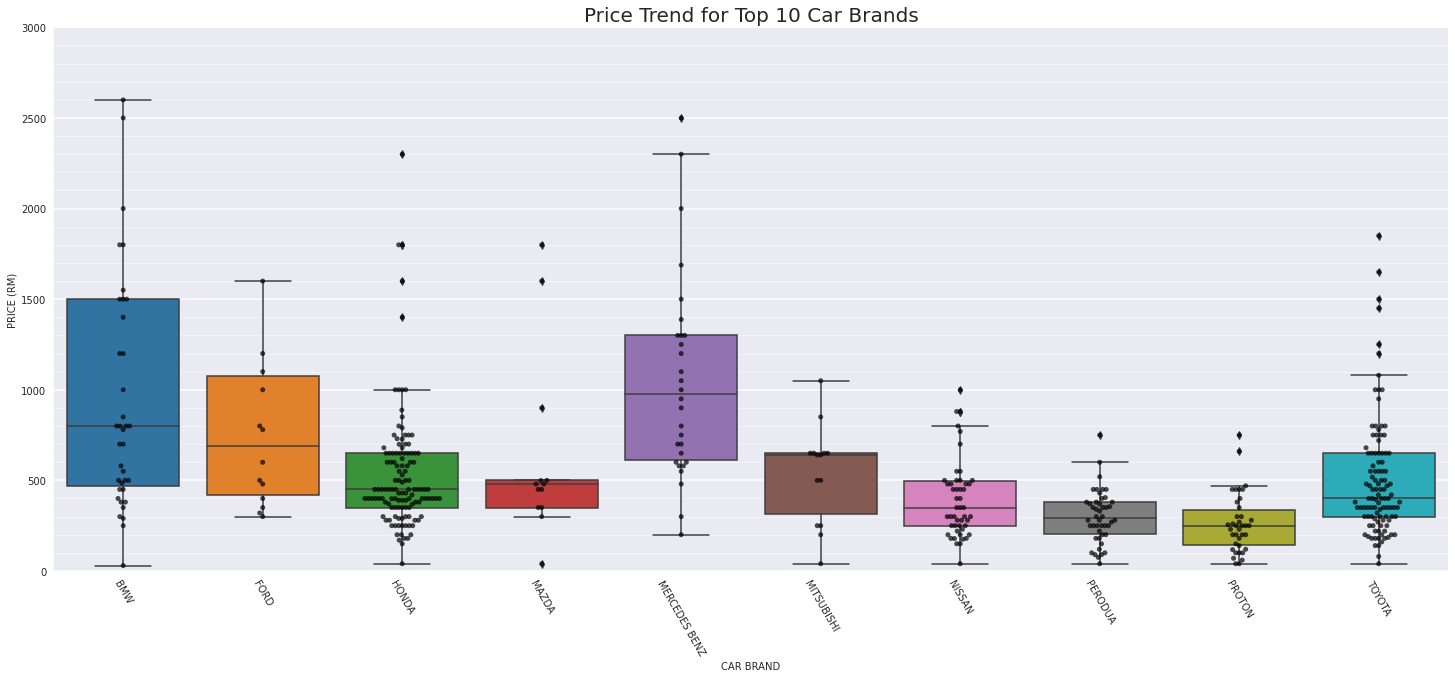

In [21]:
df_plot = pd.DataFrame(columns=['CAR BRAND', 'PRICE'])
for idx, brands in enumerate(df['carBrand_recog']):
  for brand in brands.split(','):
    new_row = {'CAR BRAND': brand, 'PRICE': df.loc[idx, 'PRICE']}
    df_plot = df_plot.append(new_row, ignore_index=True)

# Show only top 10 brands with the highest count.
df_plot['CAR BRAND'] = df_plot['CAR BRAND'].replace('', 'UNKNOWN')
df_plot.sort_values(by=['CAR BRAND'], inplace=True)
top_10_brands = df_plot['CAR BRAND'].value_counts().head(10)  

# Plot the graph
sns.set_style("darkgrid")
fig = plt.figure(figsize=(37.5, 15))

ax = sns.boxplot(x='CAR BRAND', y='PRICE', data=df_plot[df_plot['CAR BRAND'].isin(top_10_brands.index)])
sns.swarmplot(x='CAR BRAND', y='PRICE', data=df_plot[df_plot['CAR BRAND'].isin(top_10_brands.index)], color='k', alpha=0.7)

fig.set_size_inches(25,10)
plt.ylim(0, 3000)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(axis='y', b=True, which='major', linewidth=1.5)
ax.grid(axis='y', b=True, which='minor', linewidth=0.5)
ax.grid(axis='x', b=False)

ax.set_title('Price Trend for Top 10 Car Brands', fontsize=20)
plt.ylabel('PRICE (RM)')
plt.xlabel('CAR BRAND')
plt.xticks(rotation=-60)

Since we bucketed each online listing to their respective car model, we can go more granular and visualize the price trend for each individual car model. I've chosen to plot the median price to prevent outliers from skewing the data.

****Note that our data set consists of data from 9th of November 2020 to 10th of January 2020 only.**

Text(0.5, 0, 'YEAR-MONTH')

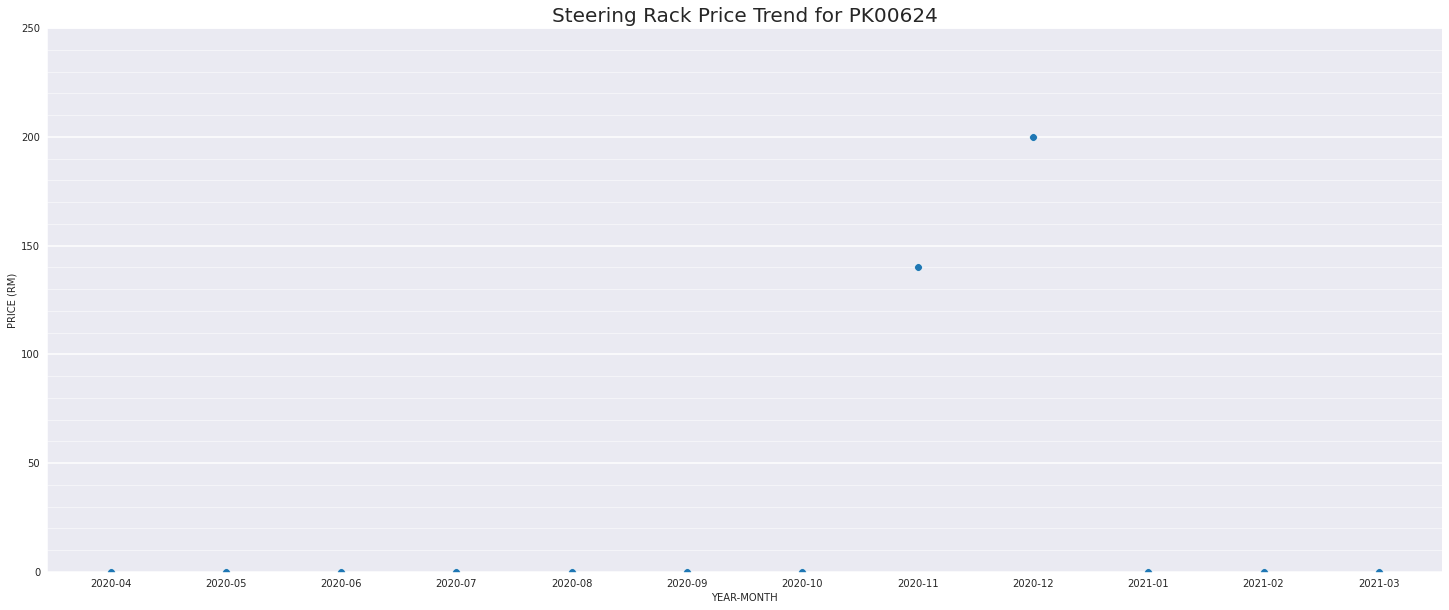

In [22]:
from datetime import date

target_item = 'PK00624'

# Set default date range to rolling 12 months.
month_start = (date.today() - relativedelta(months=12)).strftime('%Y-%m')
month_end = date.today().strftime('%Y-%m')
month_range = pd.date_range(month_start, month_end, freq='M').strftime('%Y-%m')

# Fill df with relevant data for plotting
df_plot = pd.DataFrame()
df_plot['DATE'] = month_range
for idx, date in enumerate(df_plot['DATE']):
  price_list = df[(df['Bucket'].str.contains(target_item)) & (df['LISTING DATE_month'] == date)]['PRICE']
  if price_list.empty: 
    df_plot.loc[idx, 'PRICE'] = 0
  else:
    df_plot.loc[idx, 'PRICE'] = statistics.median(price_list)

  df_plot.loc[idx, 'COUNT'] = len(df[(df['Bucket'] == target_item) & (df['LISTING DATE_month'] == date)])

# Plot the graph
sns.set_style("darkgrid")
plt.figure(figsize=(25, 10))

ax = sns.scatterplot(data=df_plot, x='DATE', y='PRICE', s=60)

ax.set(ylim=(0, max(df_plot['PRICE'])+50))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(axis='y', b=True, which='major', linewidth=1.5)
ax.grid(axis='y', b=True, which='minor', linewidth=0.5)
ax.grid(axis='x', b=False)
ax.set_title('Steering Rack Price Trend for {}'.format(target_item), fontsize=20)
plt.ylabel('PRICE (RM)')
plt.xlabel('YEAR-MONTH')

# Evaluating Accuracy <a name="evaluating-accuracy"></a>
To gauge how well our rule-based approach is working, I've taken the liberty to manually clean 556 rows of the data. The purpose is to find out how many lines are we able to clean automatically and its accuracy. Here is a summary:-

**How many car brands did we label?**

Of the 556 listings, we managed to retrieve car brands for 98.5% of the lines from either listing title or listing description. Because car brands names are unique, all of them are correctly labelled.

* 77.5% of the car brands are direct matches with keywords
* 21% of the car brands are inferred from car model
* 100% accuracy

**How many listings did we clean?**

Of the 556 listings, we managed to bucket 65% of the lines to their respective car model with 100% accuracy. The high accuracy is attributed to the fact that car model codes are unique _within_ car brands and we would only associate the car model code if we know the car brand.

* 65% are cleaned by matching both car brand and car model code
* 100% accuracy

It's worth noting that the number of lines bucketed relies on the completeness of our list of car model code. The more car model code we are able to collect in our database, the higher the accuracy. Therefore, it's important to feed new data found from manual cleaning into the database to further improve coverage.

# Going Forward

This project managed to automate ~65% of our data cleaning which is a satisfactory outcome. Can this number be higher? Well, I do believe that we can further improve the outcome by using the car model years to help infer its car model. Perhaps we can even consider an alternative source of data with a cleaner structure. The beauty of this string matching method is that, with a few minor adjustment, it will work across different datasets as well as long as it's automotive related.

But as of now, I believe it's more important that we establish the effort to maintain this cycle of data scraping, data cleaning with script, manual data cleaning, updating database until we get to a sufficiently large data pool. 

With enough data, we can deduce better insights. With better insights, better business decisions will follow.